### Experiments with training different dataset 

Goal is to see if training on high freq leads to better performance on low freq dataset than training on low freq dataset for high freq data  

8/19

Imports

In [186]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [187]:
save = False

Only for python script: uncomment if running on cluster

In [188]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [189]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [191]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [192]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # The number of different frequency components will be between 1 and 10
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes (between 0 and 1)
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [193]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 10)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 6, 10)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [194]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

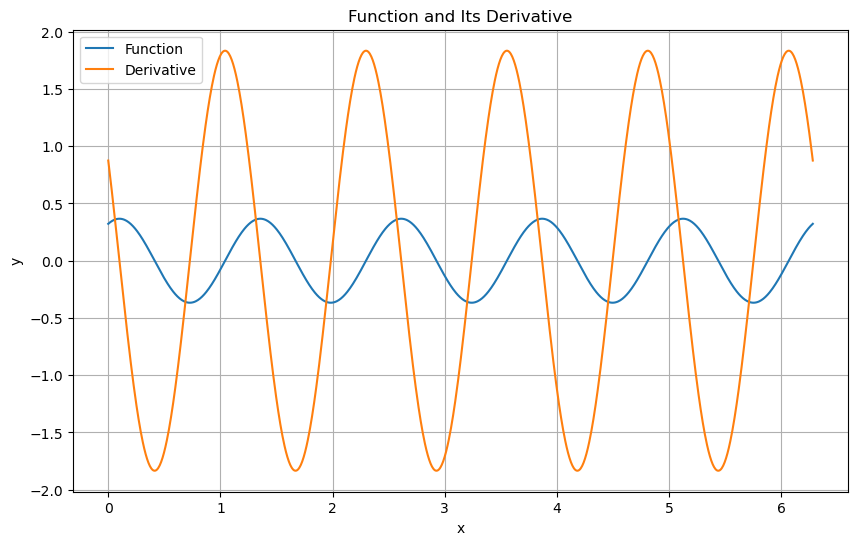

In [195]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [196]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [197]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [198]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [199]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [200]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [201]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Create models

In [202]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

## Tests to see model output frequencies

In [203]:
def plot_frequencies(function, derivative=None, residue=None, model=None):
    x = np.linspace(0, 2*np.pi, 1000)
    first_function = function

    N = 1000

    # frequencies = torch.fft.fftfreq(N, 2*np.pi/N) * 2*np.pi
    frequencies = np.fft.fftfreq(N, 1/N)
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    F = np.fft.fft(first_function.detach().numpy())
    magnitudes = np.abs(F) / N
    positive_magnitudes = magnitudes[positive_freq_indices]

    if residue:
        model.eval()
        F_derivative = np.fft.fft(derivative.detach().numpy())
        F_output = np.fft.fft(model(function.unsqueeze(0)).squeeze().detach().numpy())

        F_residue = F_derivative - F_output
        magnitudes = np.abs(F_residue) / N
        print("residue")


    # Plotting the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_magnitudes, label='Function')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of the Function')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 20)  # Adjust this based on your frequency range
    print(f"lim: 18")
    plt.show()


lim: 18


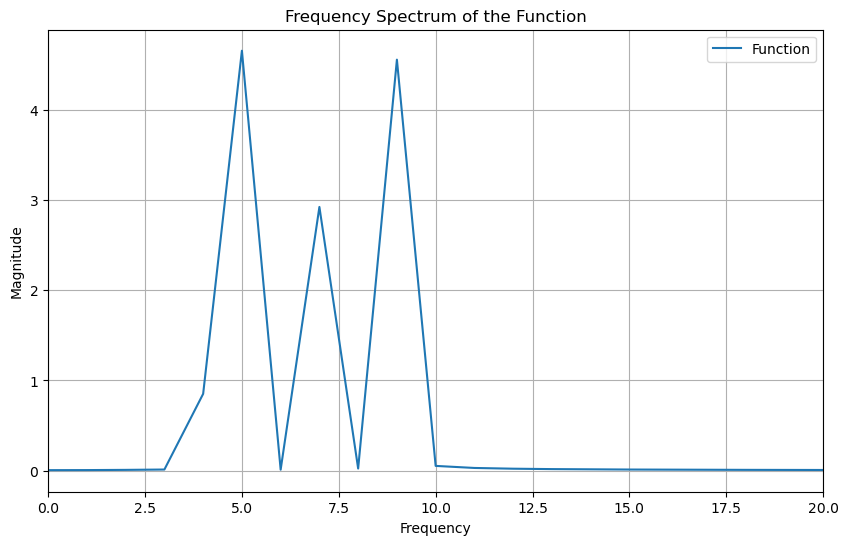

In [204]:
a = np.random.randint(0, 32)
function = test_dataset_g[a][0]
derivative = test_dataset_g[a][1]

plot_frequencies(derivative)

In [205]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)
L3ModelK3.load_state_dict(torch.load('../../models/3_layers.pth'))

L3ModelK3_untrained = SimpleCNN(n_layers=3, kernel_size=3)

lim: 18


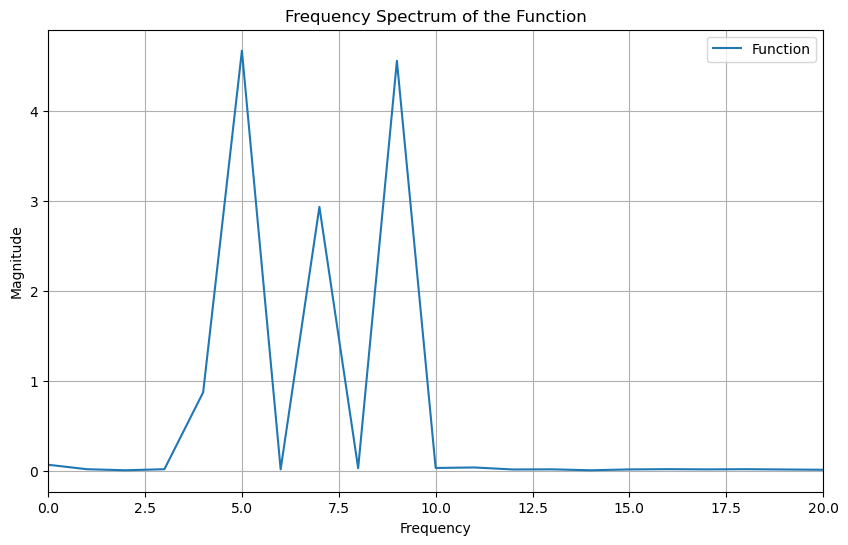

In [206]:
function1 = function.unsqueeze(0)
output = L3ModelK3(function1).squeeze()
plot_frequencies(output)

residue
lim: 18


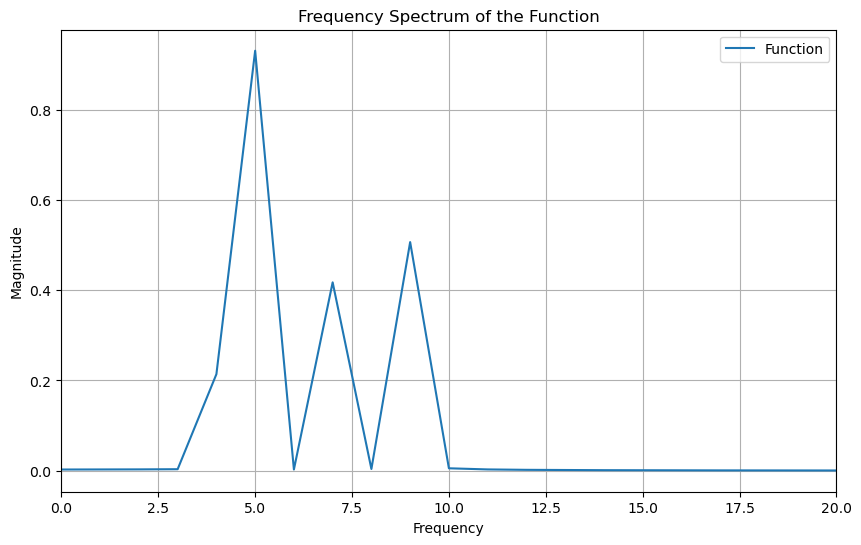

In [207]:
plot_frequencies(function=function, derivative=derivative, residue=True, model=L3ModelK3)

lim: 18


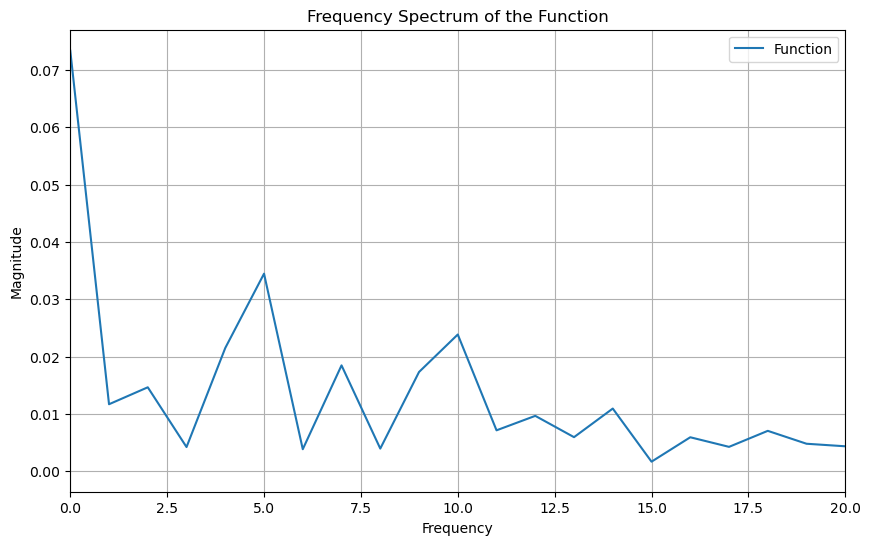

In [208]:
# This is incorrect, since we want fourier(deriv) - fourier(output) not deriv - output
plot_frequencies(derivative - output)

## Function to train model

In [209]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define a new loss function that can use NMSE
    def criterion2(target, output, nmse=None):
        mse = torch.mean((target - output) ** 2)
        if nmse:
            mse = mse / torch.mean(target ** 2)
        
        return mse

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion2(outputs, batch_derivatives, nmse=True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion2(test_outputs, b_test_derivatives, nmse=True)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [210]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

In [211]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [212]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Plot results

In [213]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

## Color map plots

In [222]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # The spacing is T / N, i.e. 2pi/1000, but since we interpret f(x)=sin(5x) to
    # have a frequency of 5 over the domain x=[0,2pi], then we scale up by 2pi 
    # to get the unit cycle back to 1
    frequencies = torch.fft.fftfreq(N, T / N) * T
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    plot_type = ''

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and not model and not residue: # If you only want the derivative
            functions = derivatives
            F = torch.fft.fft(functions)
            plot_type = "ground truth u_g'"
            
            
        elif not deriv and model and not residue: # If you only want the model output
            functions = model(functions.unsqueeze(1)).squeeze()
            F = torch.fft.fft(functions)
            plot_type = 'model output f(u_g)'

            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue and model: # If you only want the residue
            
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()
            F_outputs = torch.fft.fft(outputs)

            F_derivatives = torch.fft.fft(derivatives)

            residues = F_derivatives - F_outputs
            
            # print(f"shape of F_derivaives: {F_derivatives.shape}")
            # normalizing = F_derivatives.norm(p=2, dim=1, keepdim=True) ** 2 / F_derivatives.shape[1]
            # print(f"shape of normalizing: {normalizing}")
            # residues = residues / normalizing

            plot_type = 'spectral error'
            F = residues
            # print(f"F is: {F}")

        else:
            plot_type = 'ground truth u_g'
            F = torch.fft.fft(functions)

        # else: # If you only want the original function u_g
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)
        print(f"Plotting {plot_type}")

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs, plot_type

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0,\
    first=False, sorted_indices=None):

    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()

    
    if first:
    # Sort functions by dominant frequency
        sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
        sorted_fft = fft_amplitudes[sorted_indices]
    else:
        print("Using predefined sort")
        sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
        interpolation='nearest')

    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()

    if first:
        return sorted_indices


In [223]:
# Default is u_g
# This function plots the heatmaps for all frequencies for the test datlaoaders
def plot_heatmaps(deriv=None, model=None, residue=False, label=None, all=True, epoch=None,\
    first=False, sorted_indices=None):
    if all: # Plot all three datasets
        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_l,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'Low freq {label} at epoch {epoch}',\
            xmin=0, xmax=6, sorted_indices=sorted_indices, first=first)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}',\
            xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_h,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'High freq {label} at epoch {epoch}',\
            xmin=6, xmax=11, sorted_indices=sorted_indices, first=first)

    else: # Plot only the general frequency dataset
        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        if first:
            return plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}',\
            xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)
        else:
            plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}',\
            xmin=0, xmax=11, sorted_indices=sorted_indices, first=first)


In [224]:
train_losses, test_losses = [], []

def model_training_plots(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=False,\
        deriv=None, residue=False, lr=1e-3, heatmap=True):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = lr
    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    # If nmse, then use NMSE as loss
    if nmse:
        def criterion(target, output, nmse=None):
            mse = torch.mean((target - output) ** 2)
            mse = mse / torch.mean(target ** 2)
            
            return mse
    
    num_plots = split_freq
    split_freq = num_epochs // split_freq
    print(split_freq)

    # At the first epoch, compute the order of the functions before training
    sorted_indices = plot_heatmaps(label=f'first', all=False, first=True)
    plt.show()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)
                

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # If iteration reached, then plot the colormap once
        if heatmap:
            if (epoch) % split_freq == 0:
                print(f"Plotting the colormap once at iteration {epoch}")
                label = epoch // split_freq

                l, g, h = print_and_store_metrics(model)
                low_freq_nmses.append(l)
                general_freq_nmses.append(g)
                high_freq_nmses.append(h)
                epoch_list.append(epoch)

                # First is false here, but we pass in
                plot_heatmaps(model=model, label=f'{label}', all=False,\
                    deriv=deriv, residue=residue, epoch=epoch, sorted_indices=sorted_indices)

                plt.show()

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

Plotting spectral error
Plotting spectral error
Plotting spectral error


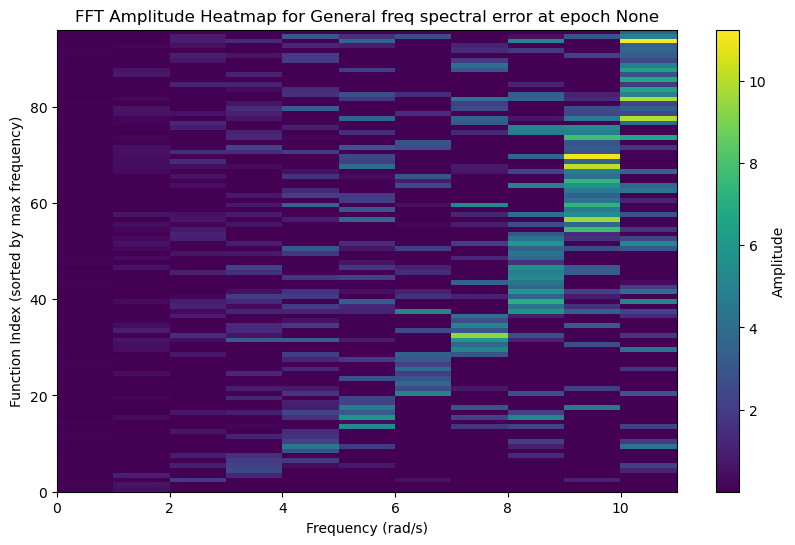

array([15, 62, 66, 68, 69, 30, 71, 13, 72, 23, 24, 76, 94, 46, 45, 86, 88,
       39,  1, 60, 43, 51,  0, 73, 74, 77, 83, 84, 90, 93, 59, 36, 95,  9,
       20,  4,  5,  7, 22, 10, 11, 12, 21, 18, 16, 14, 33, 81, 89,  3, 92,
       78, 55, 47, 31, 52, 49, 35, 34, 79, 41, 27, 29, 65, 64,  2, 56, 53,
       48, 17, 85, 70, 91, 75, 57,  8, 40, 38, 19, 44, 58, 50,  6, 37, 87,
       28, 67, 32, 42, 25, 63, 61, 54, 26, 80, 82])

In [225]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)
plot_heatmaps(model=L3ModelK3_low, residue=True, all=False, first=True)


**The above looks a lot like the trained model output or true derivative**

2
Plotting ground truth u_g
Plotting ground truth u_g
Plotting ground truth u_g


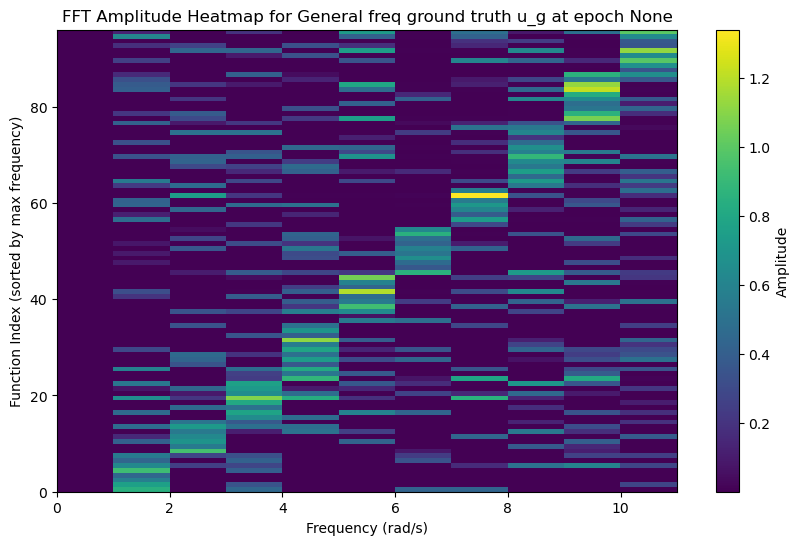

Epoch [1/100], Train Loss: 67.4822, Test Loss: 72.3752
Plotting the colormap once at iteration 0
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


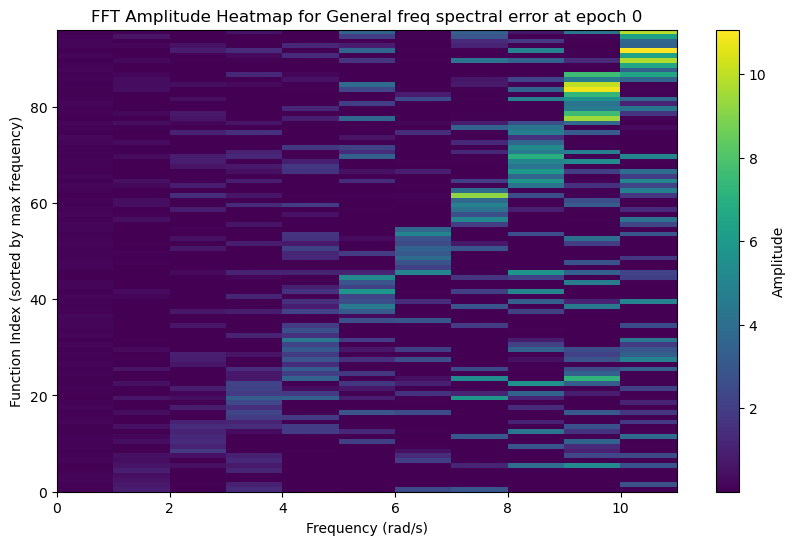

Epoch [2/100], Train Loss: 64.9633, Test Loss: 67.9335
Epoch [3/100], Train Loss: 58.7945, Test Loss: 60.4476
Plotting the colormap once at iteration 2
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


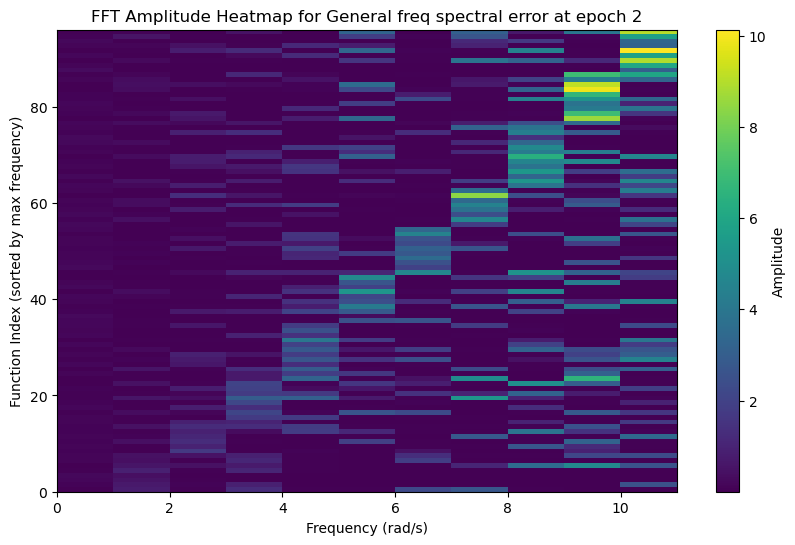

Epoch [4/100], Train Loss: 51.6863, Test Loss: 49.0437
Epoch [5/100], Train Loss: 38.4131, Test Loss: 34.7146
Plotting the colormap once at iteration 4
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


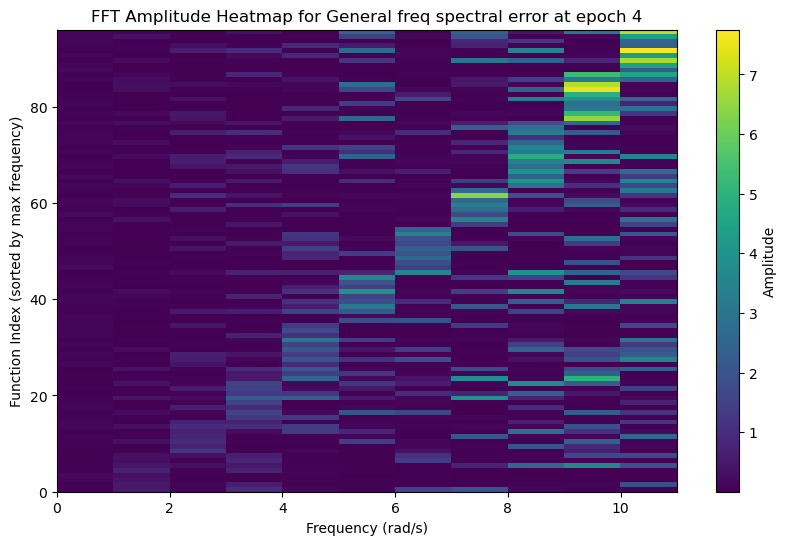

Epoch [6/100], Train Loss: 25.2645, Test Loss: 19.9236
Epoch [7/100], Train Loss: 13.4673, Test Loss: 8.9694
Plotting the colormap once at iteration 6
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


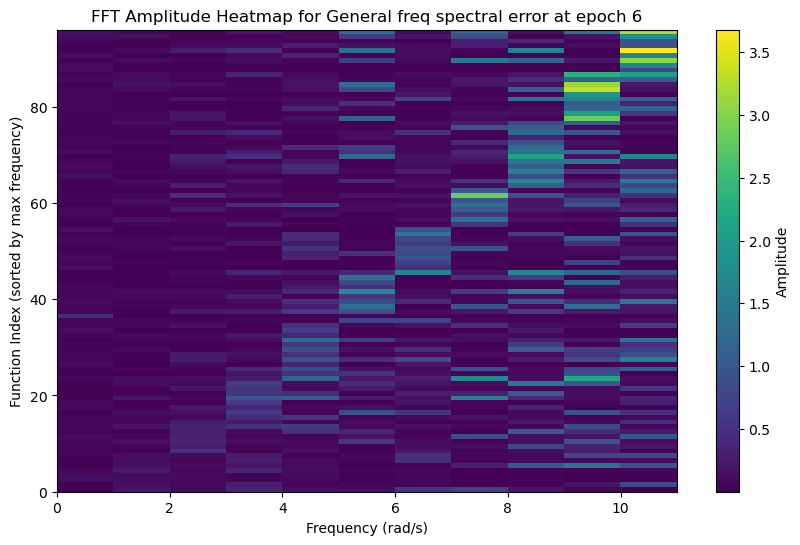

Epoch [8/100], Train Loss: 6.0770, Test Loss: 4.6248
Epoch [9/100], Train Loss: 3.9854, Test Loss: 3.8769
Plotting the colormap once at iteration 8
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


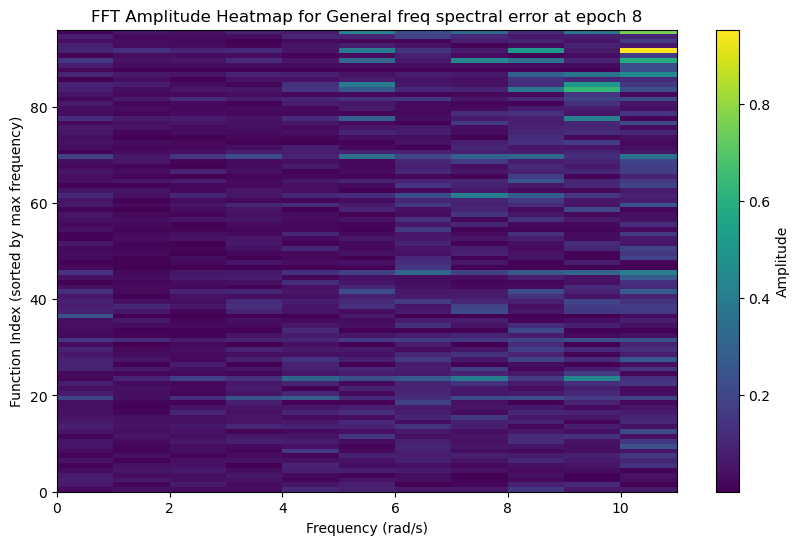

Epoch [10/100], Train Loss: 3.5341, Test Loss: 3.4563
Epoch [11/100], Train Loss: 3.2095, Test Loss: 3.2159
Plotting the colormap once at iteration 10
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


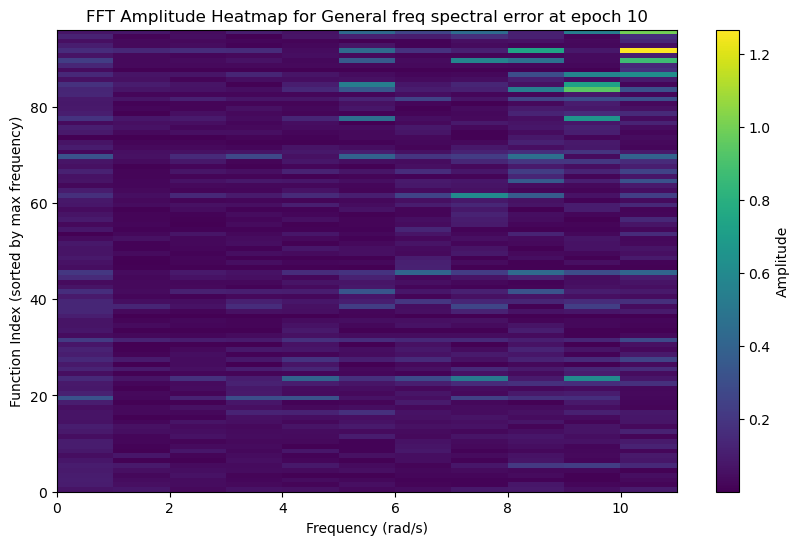

Epoch [12/100], Train Loss: 3.0045, Test Loss: 3.0526
Epoch [13/100], Train Loss: 2.9221, Test Loss: 2.9416
Plotting the colormap once at iteration 12
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


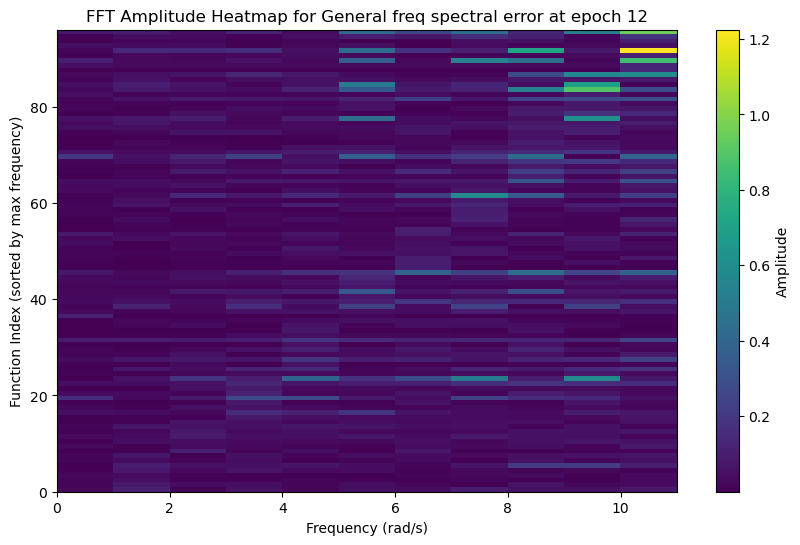

Epoch [14/100], Train Loss: 2.8014, Test Loss: 2.8140
Epoch [15/100], Train Loss: 2.6839, Test Loss: 2.7337
Plotting the colormap once at iteration 14
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


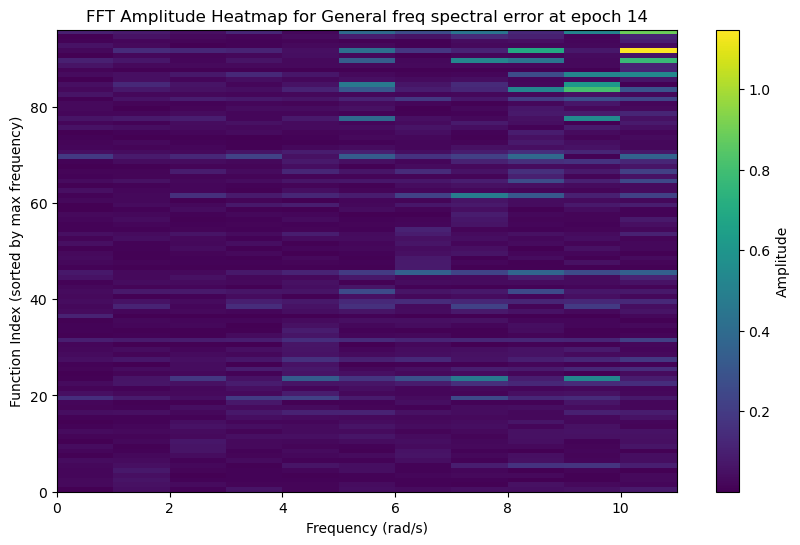

Epoch [16/100], Train Loss: 2.5999, Test Loss: 2.6615
Epoch [17/100], Train Loss: 2.5602, Test Loss: 2.5841
Plotting the colormap once at iteration 16
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


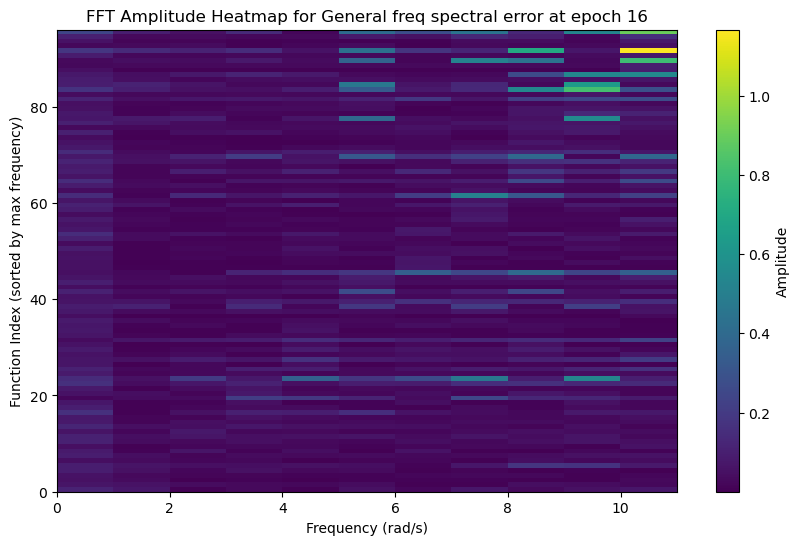

Epoch [18/100], Train Loss: 2.4354, Test Loss: 2.4969
Epoch [19/100], Train Loss: 2.3655, Test Loss: 2.4181
Plotting the colormap once at iteration 18
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


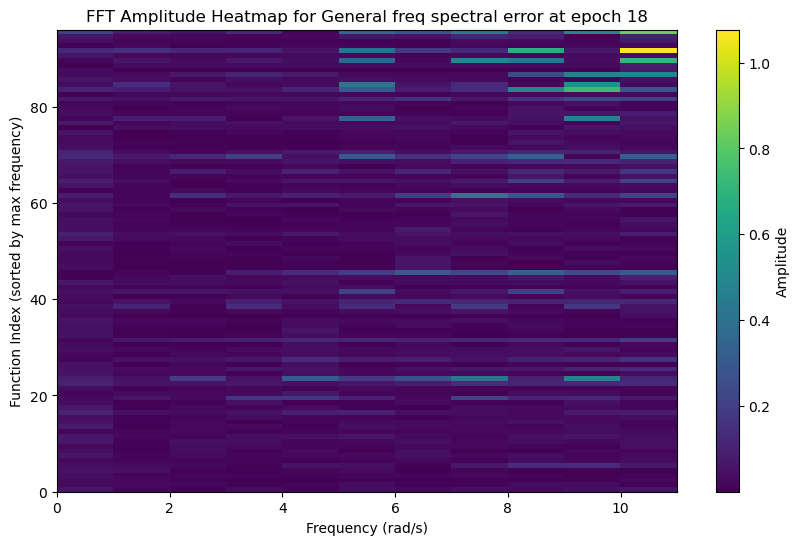

Epoch [20/100], Train Loss: 2.2747, Test Loss: 2.3574
Epoch [21/100], Train Loss: 2.2284, Test Loss: 2.2976
Plotting the colormap once at iteration 20
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


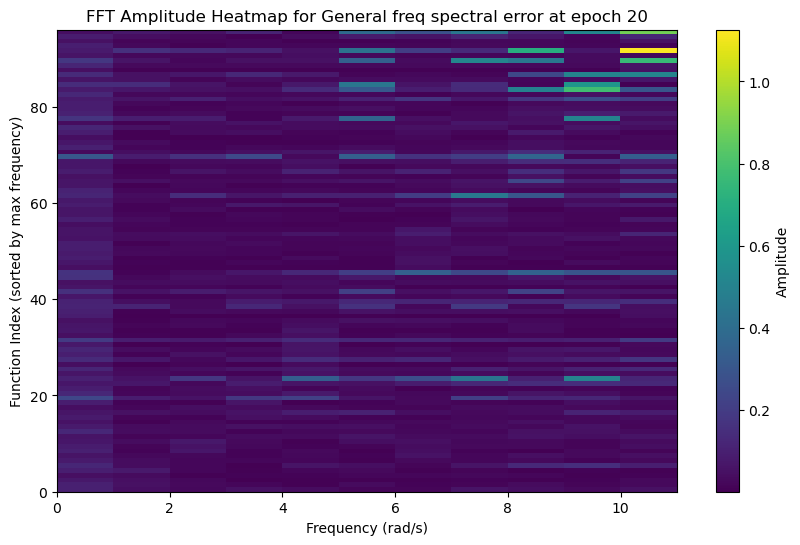

Epoch [22/100], Train Loss: 2.2148, Test Loss: 2.2155
Epoch [23/100], Train Loss: 2.0914, Test Loss: 2.1567
Plotting the colormap once at iteration 22
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


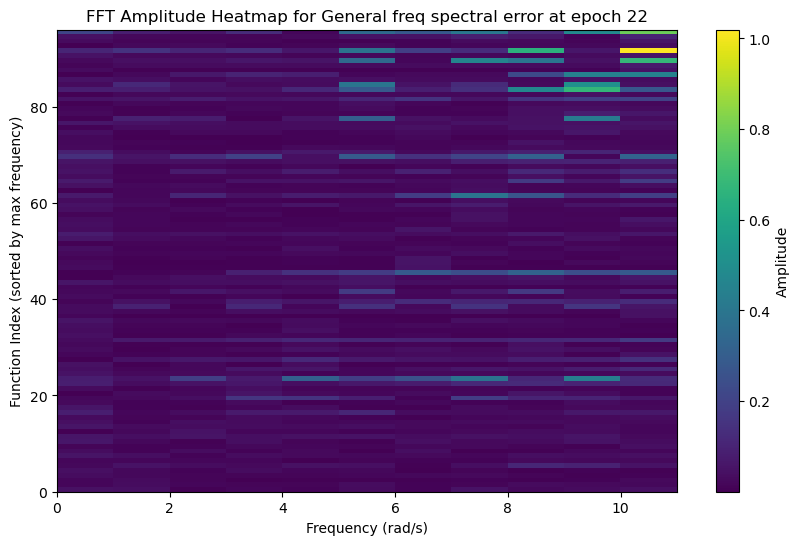

Epoch [24/100], Train Loss: 2.0615, Test Loss: 2.0913
Epoch [25/100], Train Loss: 1.9499, Test Loss: 2.0312
Plotting the colormap once at iteration 24
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


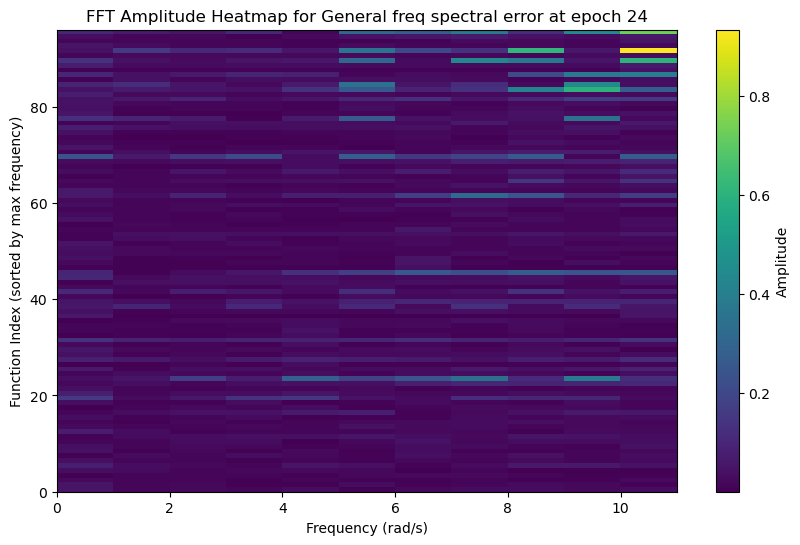

Epoch [26/100], Train Loss: 1.9249, Test Loss: 1.9687
Epoch [27/100], Train Loss: 1.8664, Test Loss: 1.9163
Plotting the colormap once at iteration 26
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


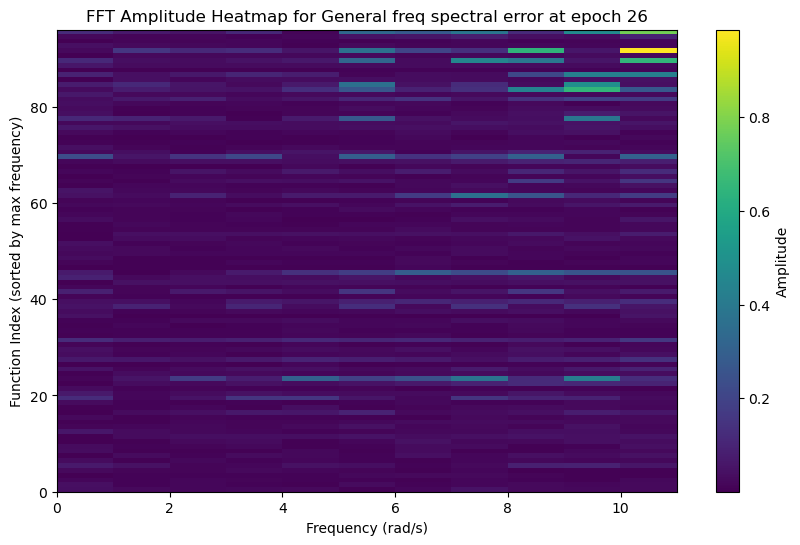

Epoch [28/100], Train Loss: 1.8445, Test Loss: 1.8583
Epoch [29/100], Train Loss: 1.7841, Test Loss: 1.8076
Plotting the colormap once at iteration 28
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


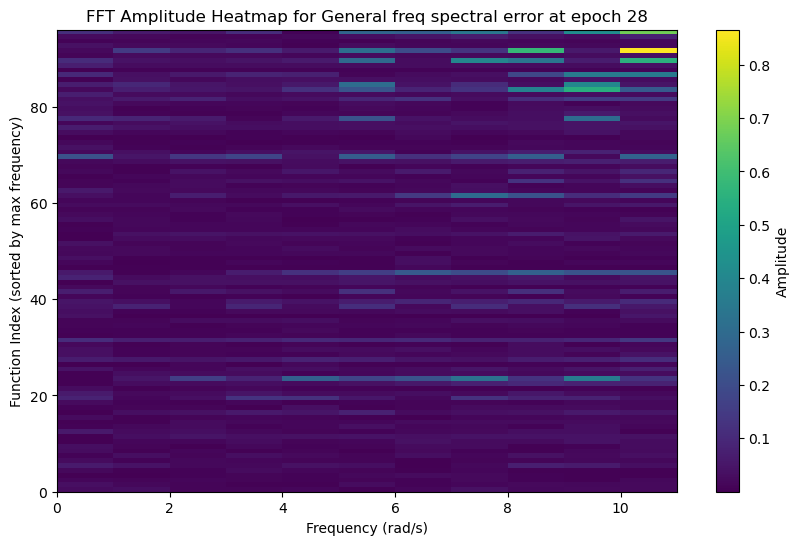

Epoch [30/100], Train Loss: 1.7776, Test Loss: 1.7840
Epoch [31/100], Train Loss: 1.6753, Test Loss: 1.7194
Plotting the colormap once at iteration 30
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


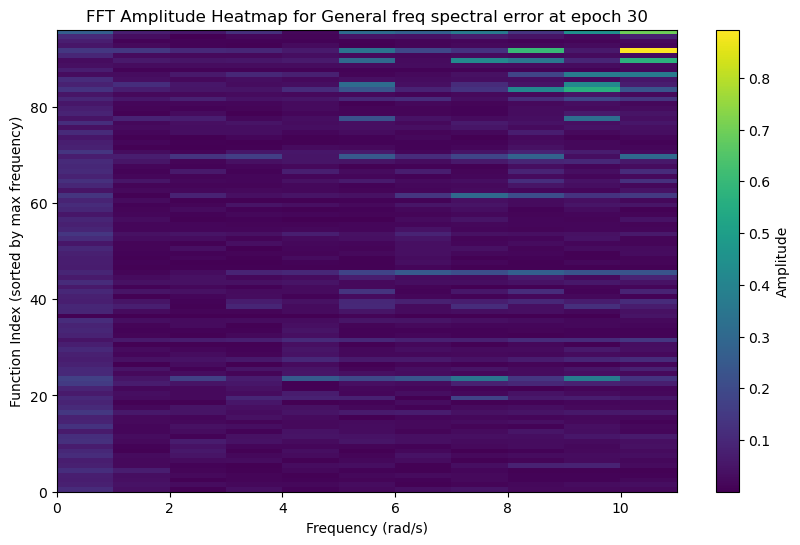

Epoch [32/100], Train Loss: 1.5925, Test Loss: 1.6611
Epoch [33/100], Train Loss: 1.6067, Test Loss: 1.6116
Plotting the colormap once at iteration 32
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


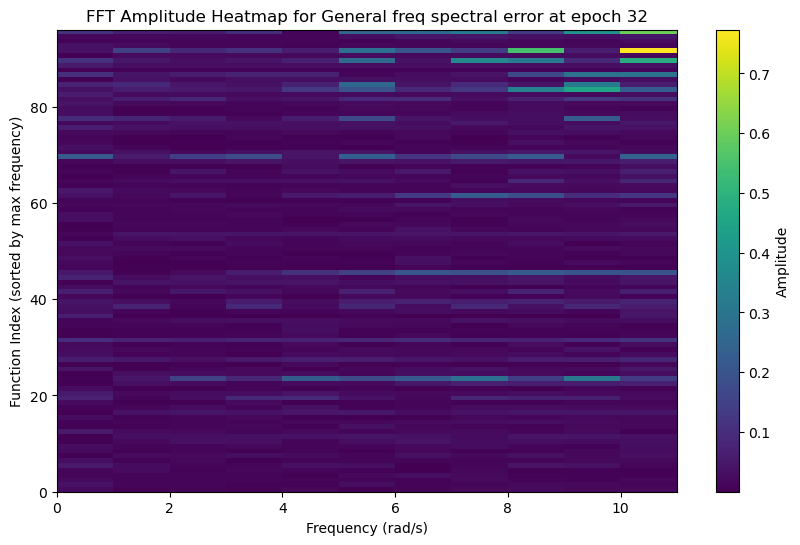

Epoch [34/100], Train Loss: 1.5188, Test Loss: 1.5638
Epoch [35/100], Train Loss: 1.4664, Test Loss: 1.5181
Plotting the colormap once at iteration 34
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


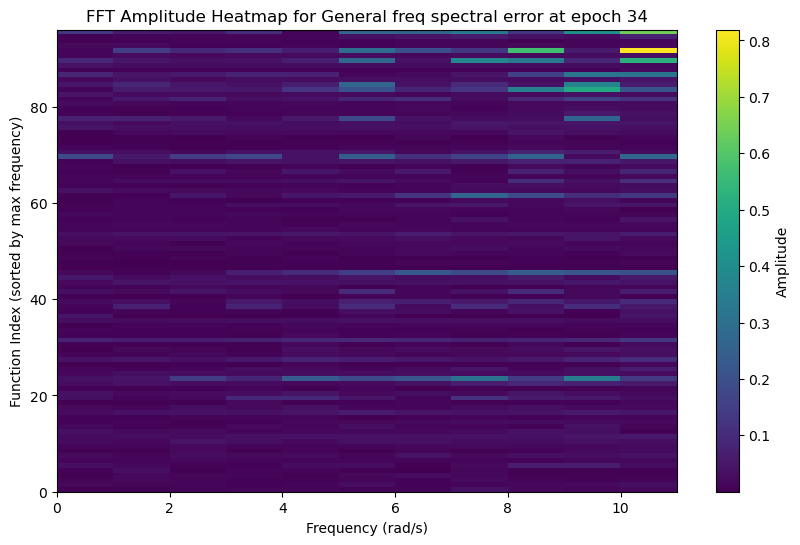

Epoch [36/100], Train Loss: 1.4817, Test Loss: 1.4766
Epoch [37/100], Train Loss: 1.4093, Test Loss: 1.4591
Plotting the colormap once at iteration 36
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


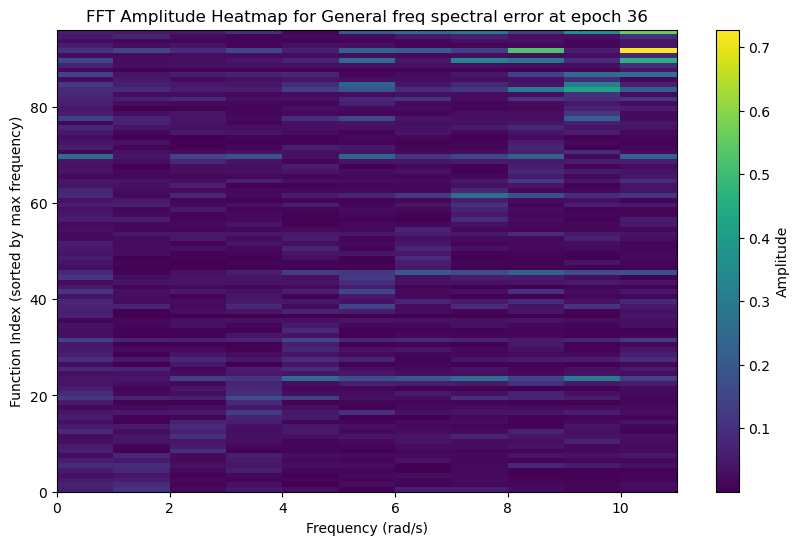

Epoch [38/100], Train Loss: 1.3639, Test Loss: 1.3906
Epoch [39/100], Train Loss: 1.3429, Test Loss: 1.3486
Plotting the colormap once at iteration 38
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


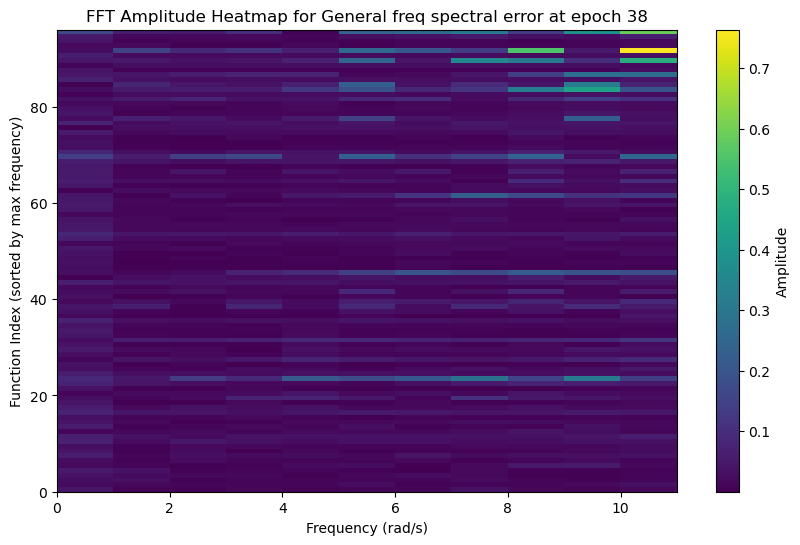

Epoch [40/100], Train Loss: 1.2810, Test Loss: 1.3090
Epoch [41/100], Train Loss: 1.2507, Test Loss: 1.2693
Plotting the colormap once at iteration 40
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


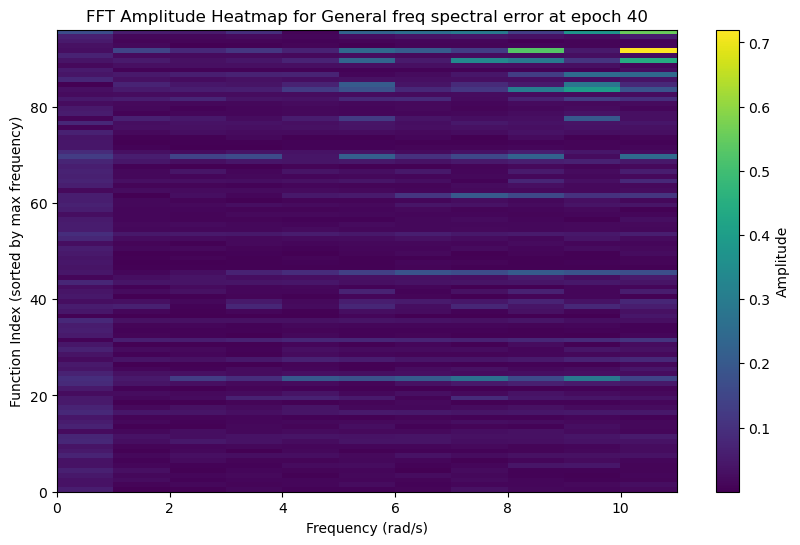

Epoch [42/100], Train Loss: 1.2384, Test Loss: 1.2543
Epoch [43/100], Train Loss: 1.2288, Test Loss: 1.2656
Plotting the colormap once at iteration 42
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


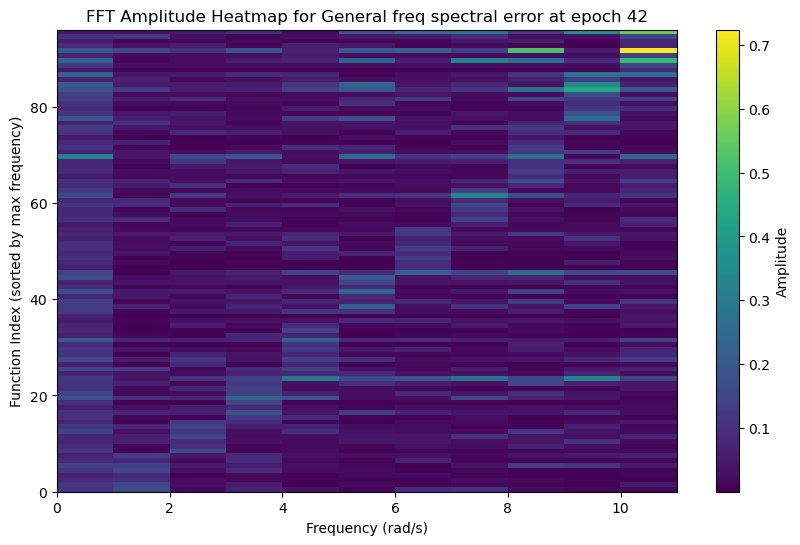

Epoch [44/100], Train Loss: 1.2273, Test Loss: 1.1623
Epoch [45/100], Train Loss: 1.1545, Test Loss: 1.1343
Plotting the colormap once at iteration 44
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


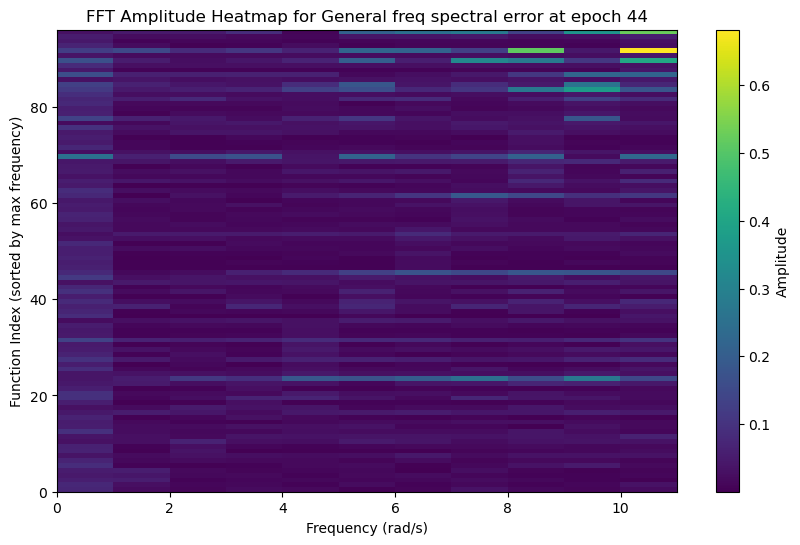

Epoch [46/100], Train Loss: 1.0988, Test Loss: 1.1062
Epoch [47/100], Train Loss: 1.0656, Test Loss: 1.0711
Plotting the colormap once at iteration 46
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


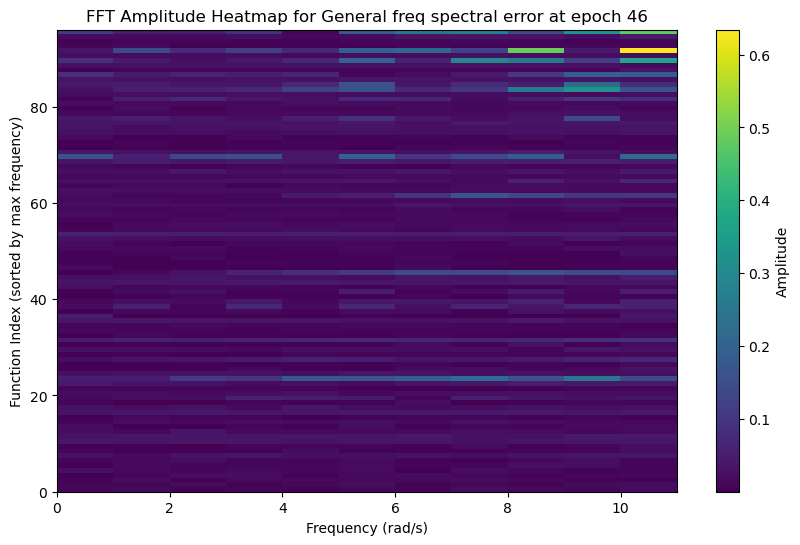

Epoch [48/100], Train Loss: 1.0353, Test Loss: 1.0490
Epoch [49/100], Train Loss: 1.0232, Test Loss: 1.0204
Plotting the colormap once at iteration 48
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


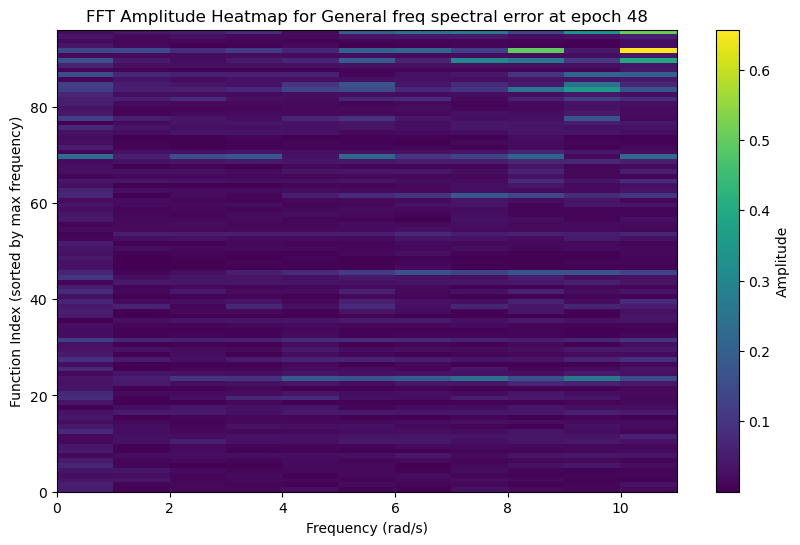

Epoch [50/100], Train Loss: 0.9909, Test Loss: 0.9907
Epoch [51/100], Train Loss: 0.9691, Test Loss: 0.9691
Plotting the colormap once at iteration 50
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


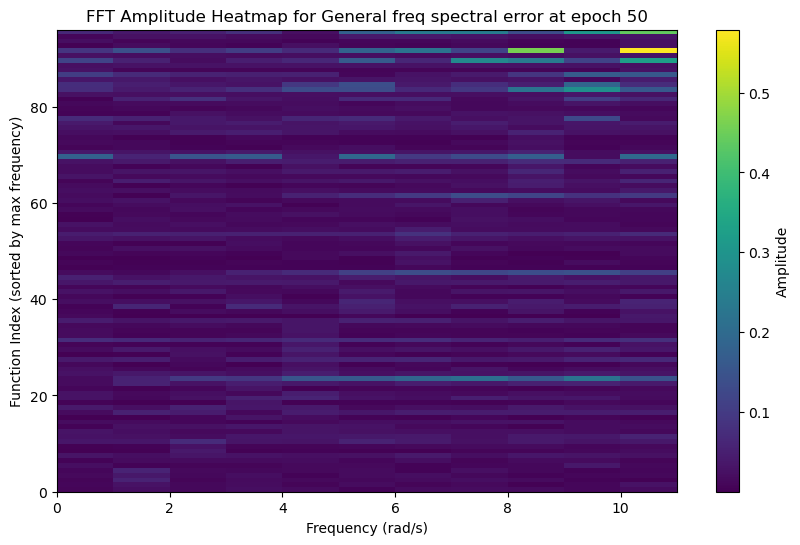

Epoch [52/100], Train Loss: 0.9066, Test Loss: 0.9435
Epoch [53/100], Train Loss: 0.9093, Test Loss: 0.9221
Plotting the colormap once at iteration 52
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


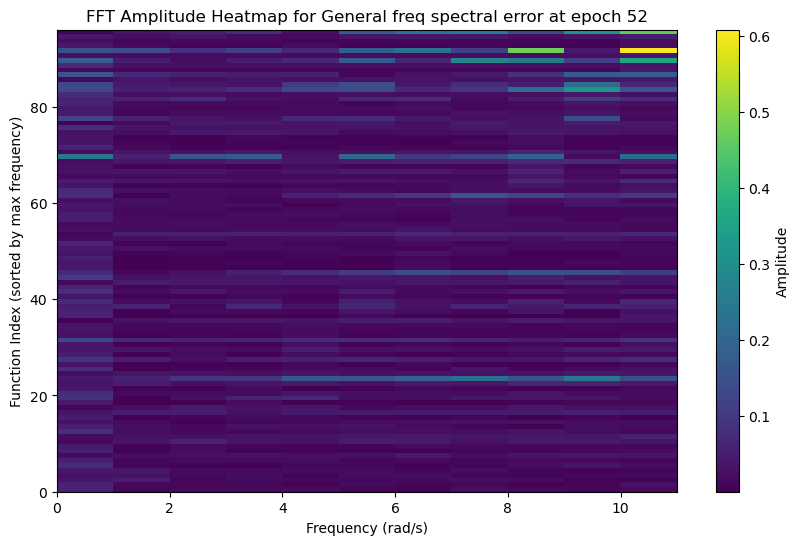

Epoch [54/100], Train Loss: 0.8751, Test Loss: 0.8963
Epoch [55/100], Train Loss: 0.8696, Test Loss: 0.8740
Plotting the colormap once at iteration 54
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


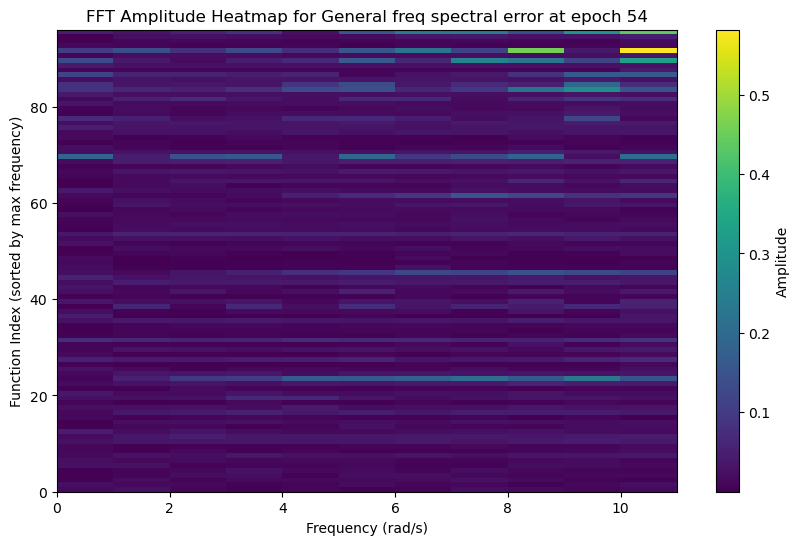

Epoch [56/100], Train Loss: 0.8532, Test Loss: 0.8536
Epoch [57/100], Train Loss: 0.8343, Test Loss: 0.8398
Plotting the colormap once at iteration 56
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


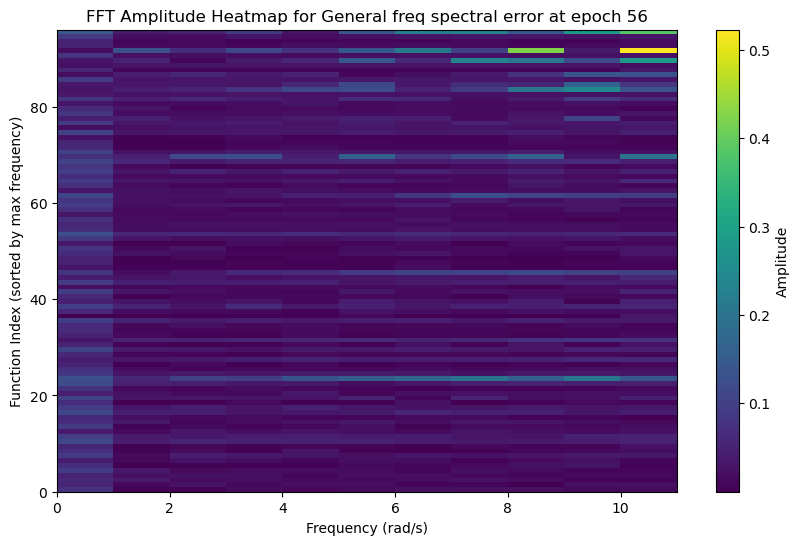

Epoch [58/100], Train Loss: 0.8210, Test Loss: 0.8170
Epoch [59/100], Train Loss: 0.7993, Test Loss: 0.8068
Plotting the colormap once at iteration 58
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


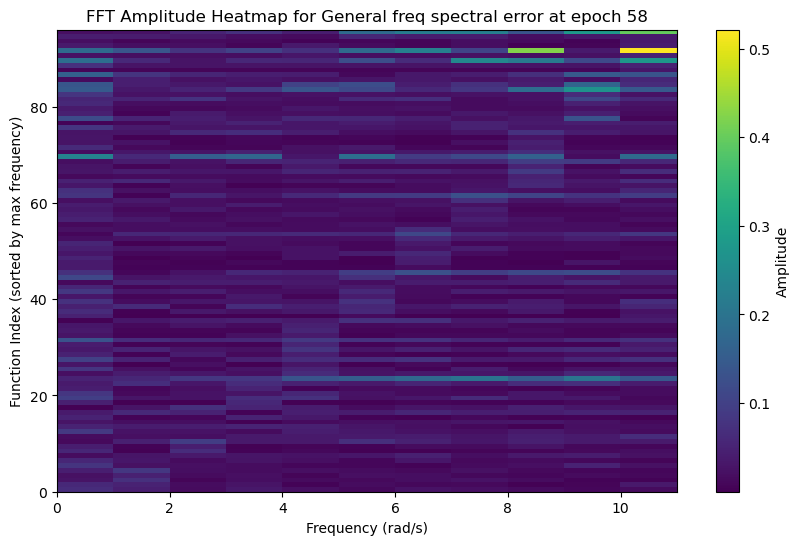

Epoch [60/100], Train Loss: 0.8167, Test Loss: 0.7950
Epoch [61/100], Train Loss: 0.7724, Test Loss: 0.8081
Plotting the colormap once at iteration 60
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


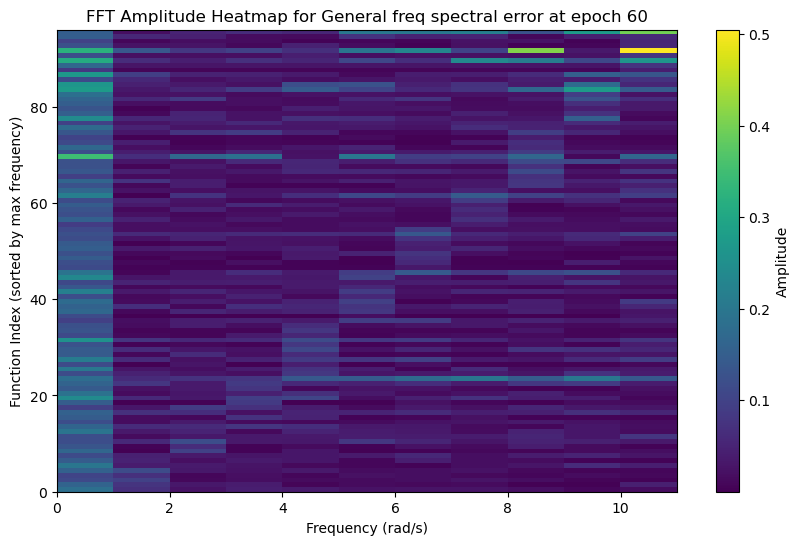

Epoch [62/100], Train Loss: 0.7670, Test Loss: 0.7532
Epoch [63/100], Train Loss: 0.7227, Test Loss: 0.7333
Plotting the colormap once at iteration 62
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


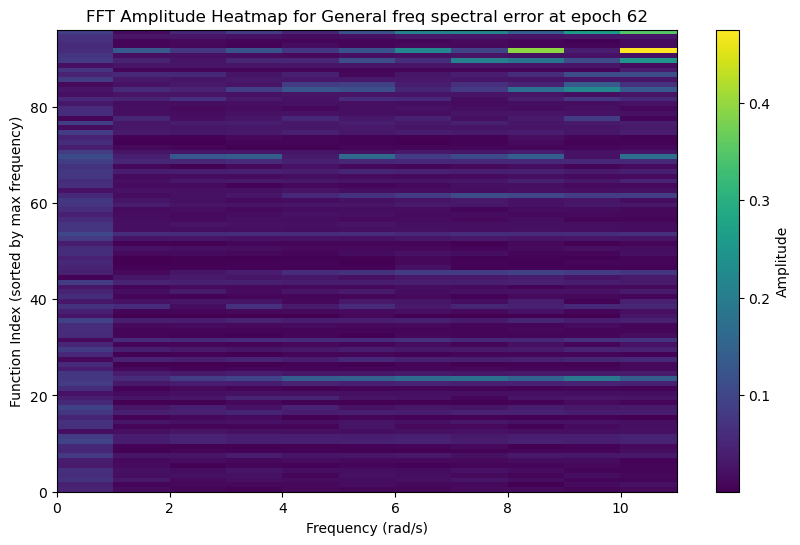

Epoch [64/100], Train Loss: 0.7159, Test Loss: 0.7198
Epoch [65/100], Train Loss: 0.6974, Test Loss: 0.7064
Plotting the colormap once at iteration 64
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


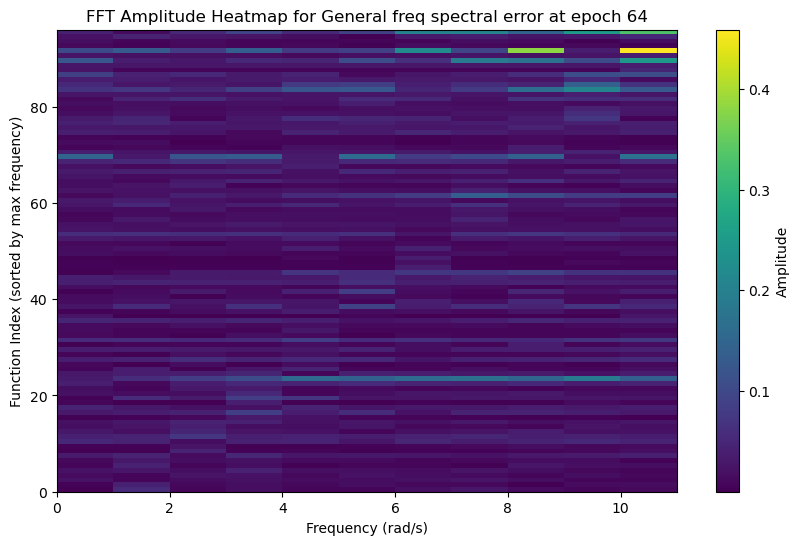

Epoch [66/100], Train Loss: 0.6713, Test Loss: 0.6932
Epoch [67/100], Train Loss: 0.6669, Test Loss: 0.6790
Plotting the colormap once at iteration 66
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


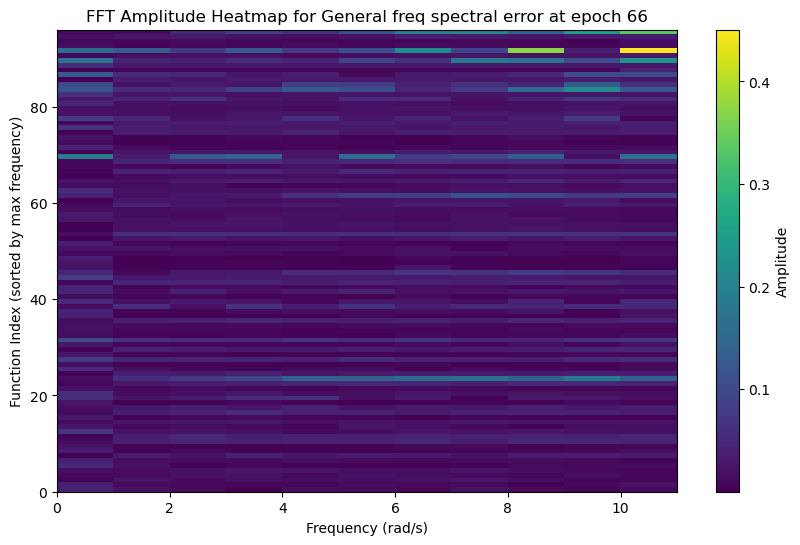

Epoch [68/100], Train Loss: 0.6563, Test Loss: 0.6783
Epoch [69/100], Train Loss: 0.6497, Test Loss: 0.6555
Plotting the colormap once at iteration 68
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


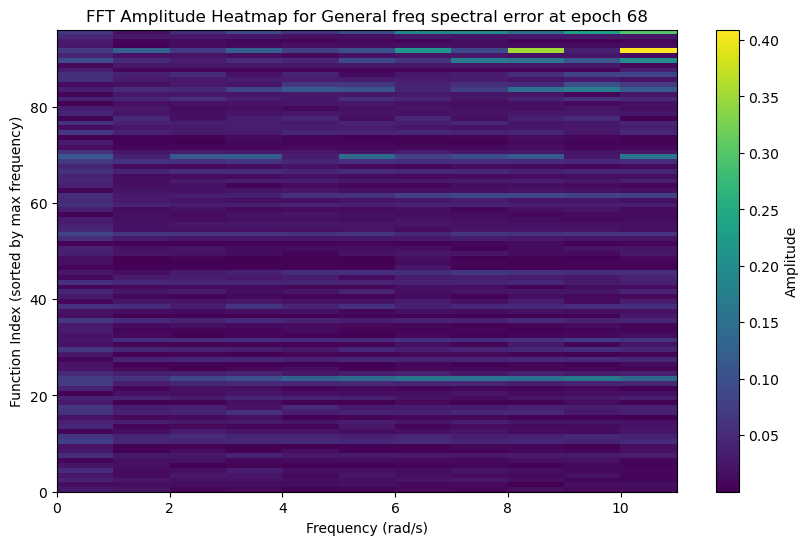

Epoch [70/100], Train Loss: 0.6484, Test Loss: 0.6515
Epoch [71/100], Train Loss: 0.6377, Test Loss: 0.6536
Plotting the colormap once at iteration 70
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


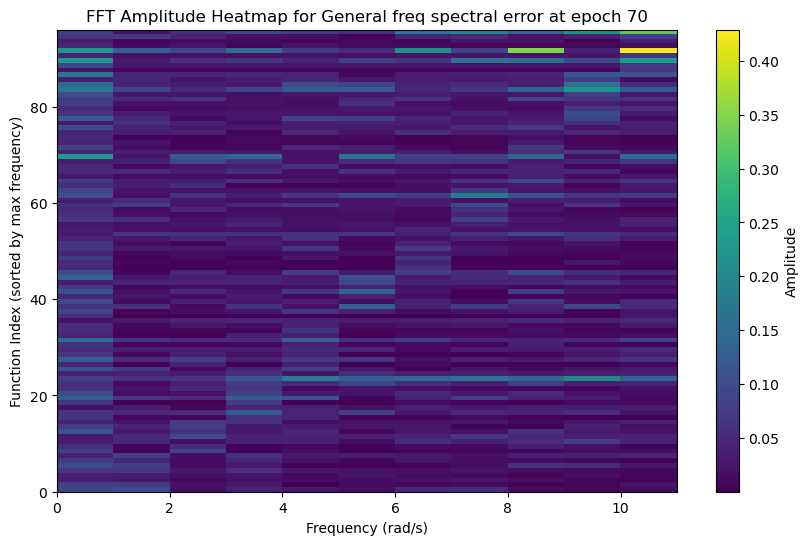

Epoch [72/100], Train Loss: 0.6178, Test Loss: 0.6213
Epoch [73/100], Train Loss: 0.6015, Test Loss: 0.6107
Plotting the colormap once at iteration 72
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


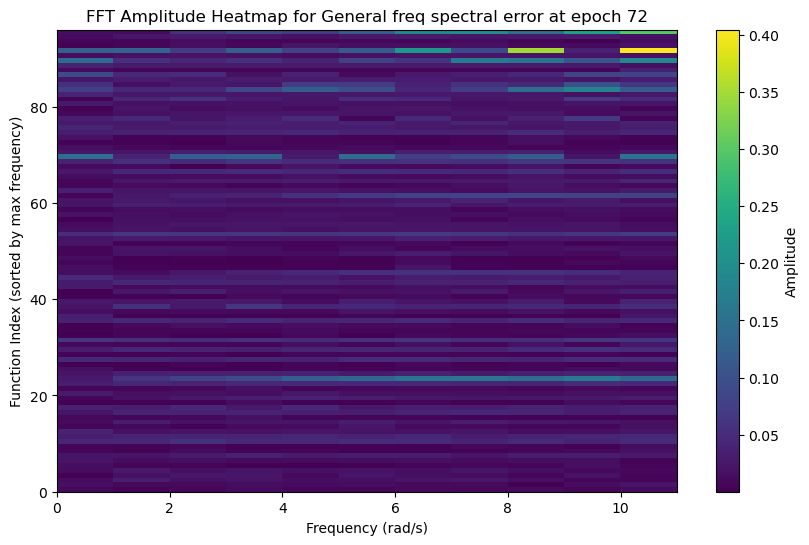

Epoch [74/100], Train Loss: 0.5856, Test Loss: 0.6118
Epoch [75/100], Train Loss: 0.5942, Test Loss: 0.5967
Plotting the colormap once at iteration 74
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


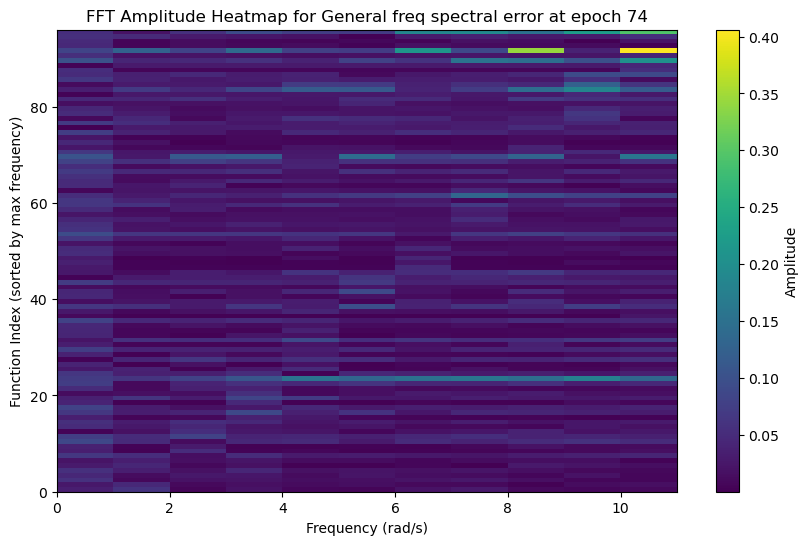

Epoch [76/100], Train Loss: 0.5836, Test Loss: 0.5855
Epoch [77/100], Train Loss: 0.5772, Test Loss: 0.6012
Plotting the colormap once at iteration 76
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


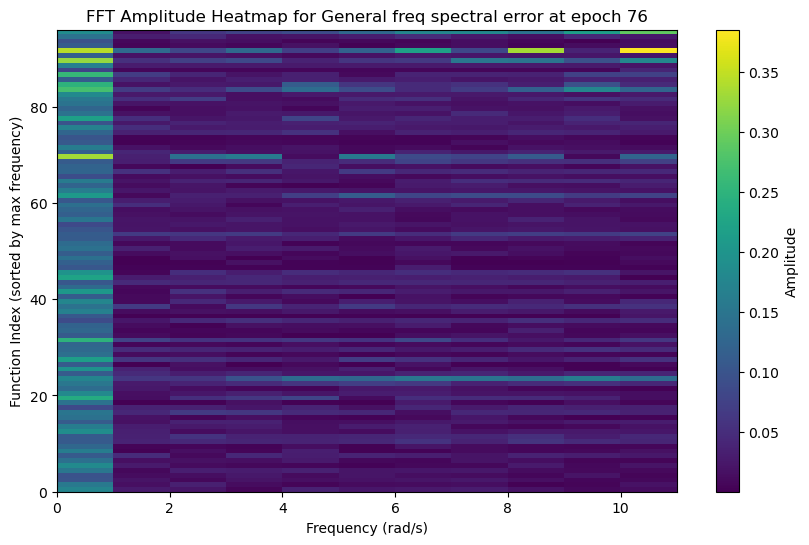

Epoch [78/100], Train Loss: 0.5646, Test Loss: 0.6242
Epoch [79/100], Train Loss: 0.5638, Test Loss: 0.5669
Plotting the colormap once at iteration 78
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


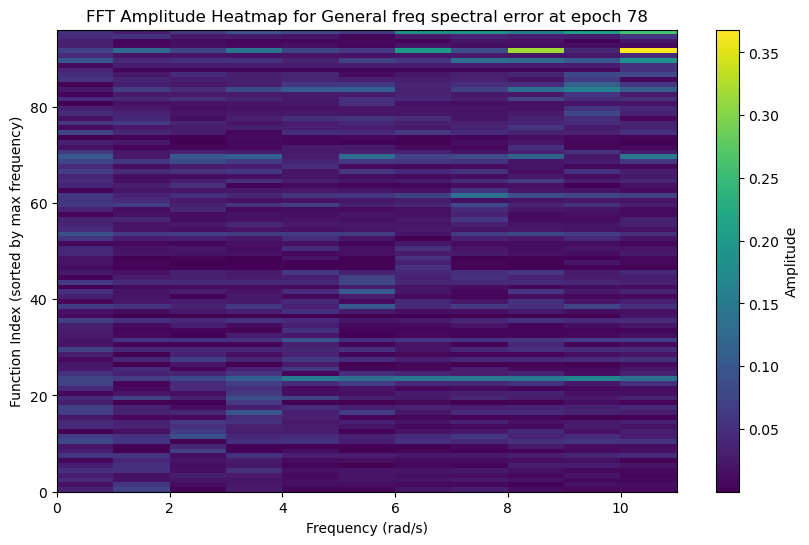

Epoch [80/100], Train Loss: 0.5494, Test Loss: 0.5534
Epoch [81/100], Train Loss: 0.5322, Test Loss: 0.5743
Plotting the colormap once at iteration 80
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


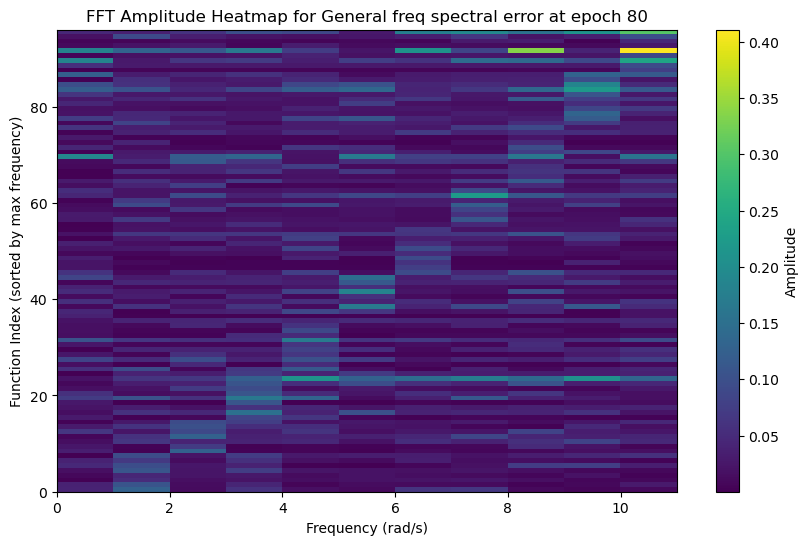

Epoch [82/100], Train Loss: 0.5427, Test Loss: 0.5583
Epoch [83/100], Train Loss: 0.5359, Test Loss: 0.5792
Plotting the colormap once at iteration 82
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


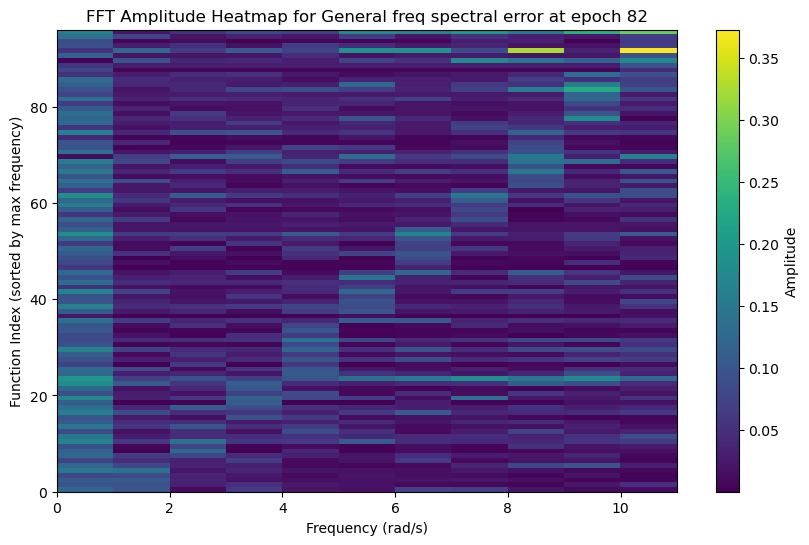

Epoch [84/100], Train Loss: 0.5355, Test Loss: 0.5815
Epoch [85/100], Train Loss: 0.5390, Test Loss: 0.5376
Plotting the colormap once at iteration 84
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


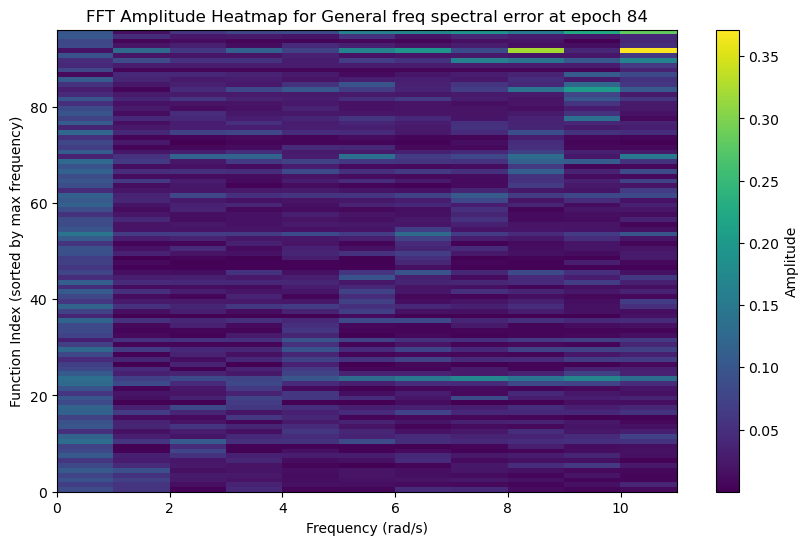

Epoch [86/100], Train Loss: 0.4854, Test Loss: 0.5289
Epoch [87/100], Train Loss: 0.5233, Test Loss: 0.5179
Plotting the colormap once at iteration 86
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


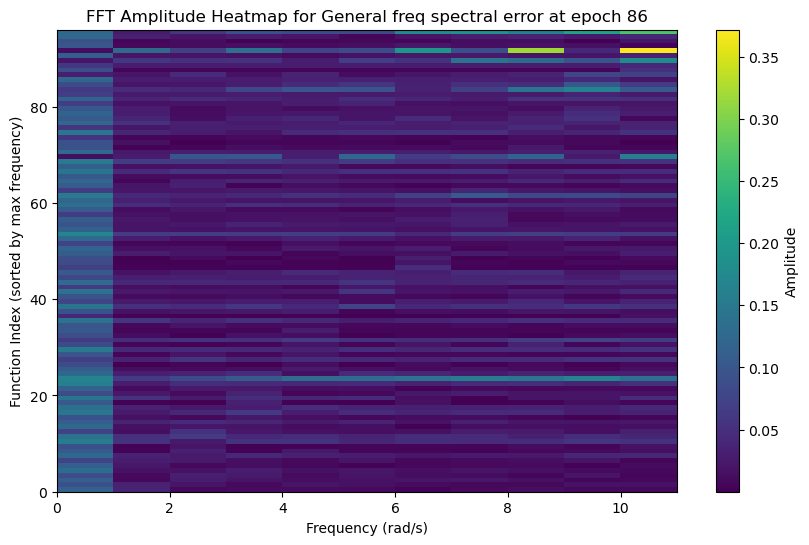

Epoch [88/100], Train Loss: 0.5173, Test Loss: 0.5090
Epoch [89/100], Train Loss: 0.4889, Test Loss: 0.5316
Plotting the colormap once at iteration 88
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


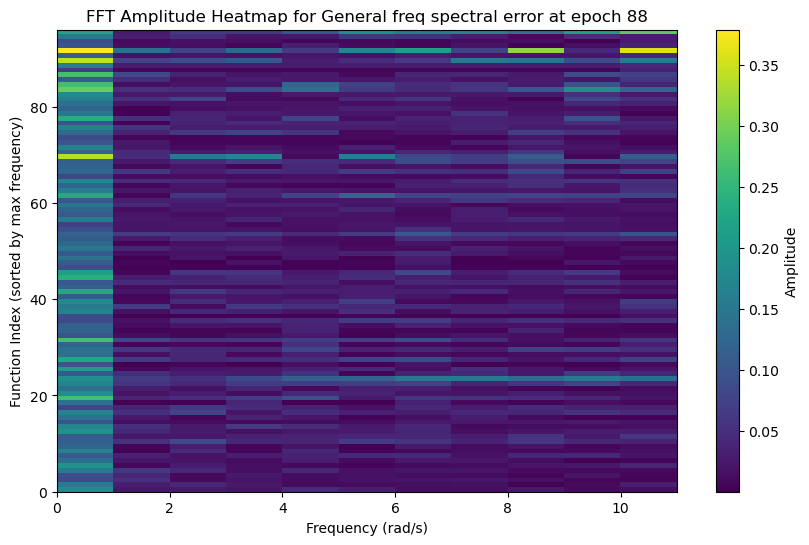

Epoch [90/100], Train Loss: 0.5283, Test Loss: 0.5484
Epoch [91/100], Train Loss: 0.5268, Test Loss: 0.4994
Plotting the colormap once at iteration 90
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


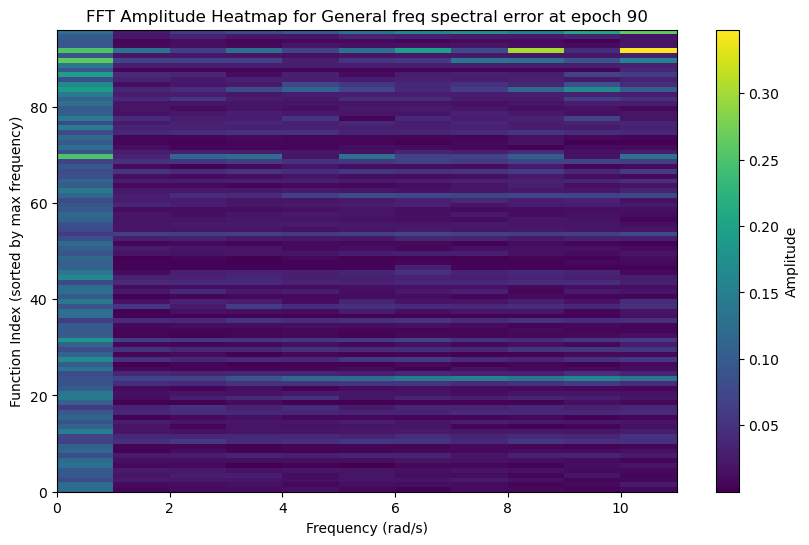

Epoch [92/100], Train Loss: 0.4816, Test Loss: 0.5041
Epoch [93/100], Train Loss: 0.4642, Test Loss: 0.4918
Plotting the colormap once at iteration 92
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


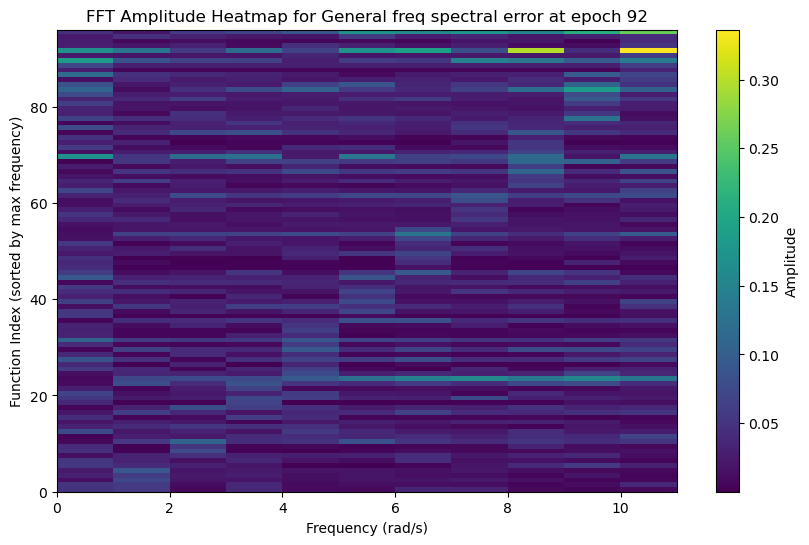

Epoch [94/100], Train Loss: 0.4459, Test Loss: 0.4874
Epoch [95/100], Train Loss: 0.4579, Test Loss: 0.4767
Plotting the colormap once at iteration 94
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


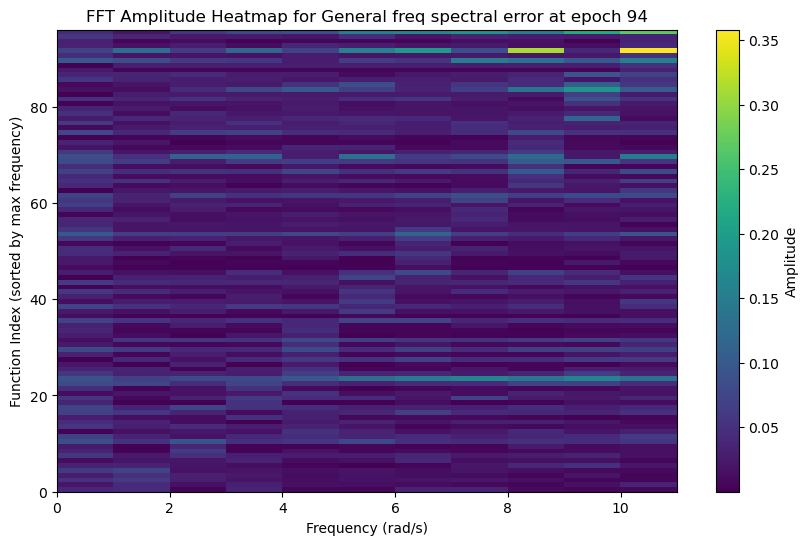

Epoch [96/100], Train Loss: 0.4580, Test Loss: 0.4671
Epoch [97/100], Train Loss: 0.4613, Test Loss: 0.4756
Plotting the colormap once at iteration 96
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


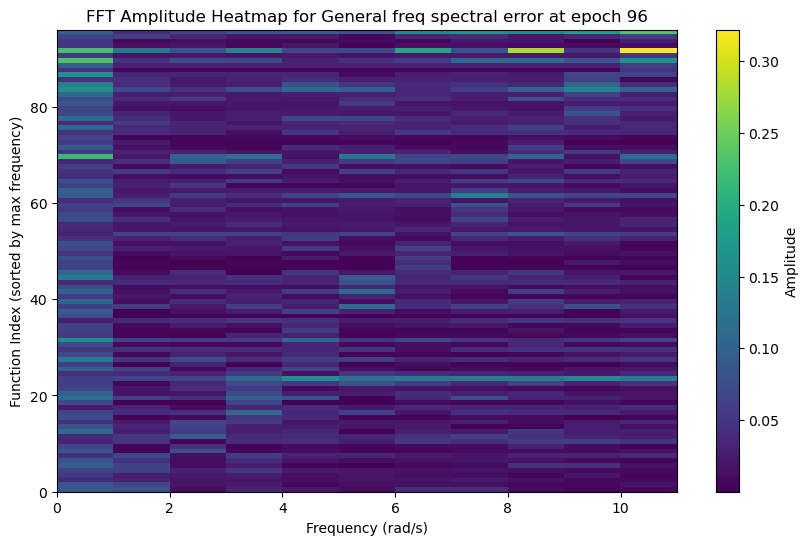

Epoch [98/100], Train Loss: 0.4524, Test Loss: 0.4700
Epoch [99/100], Train Loss: 0.4488, Test Loss: 0.4754
Plotting the colormap once at iteration 98
Plotting spectral error
Plotting spectral error
Plotting spectral error
Using predefined sort


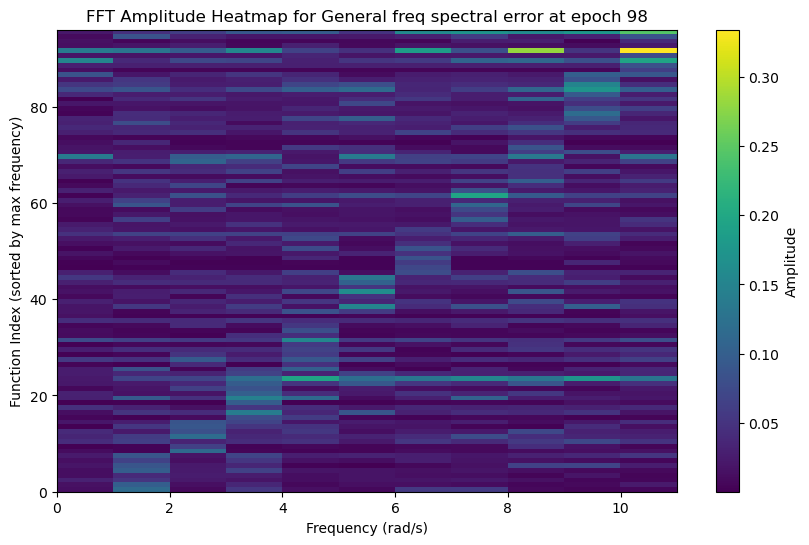

Epoch [100/100], Train Loss: 0.4519, Test Loss: 0.4632
Training finished for firstst derivative


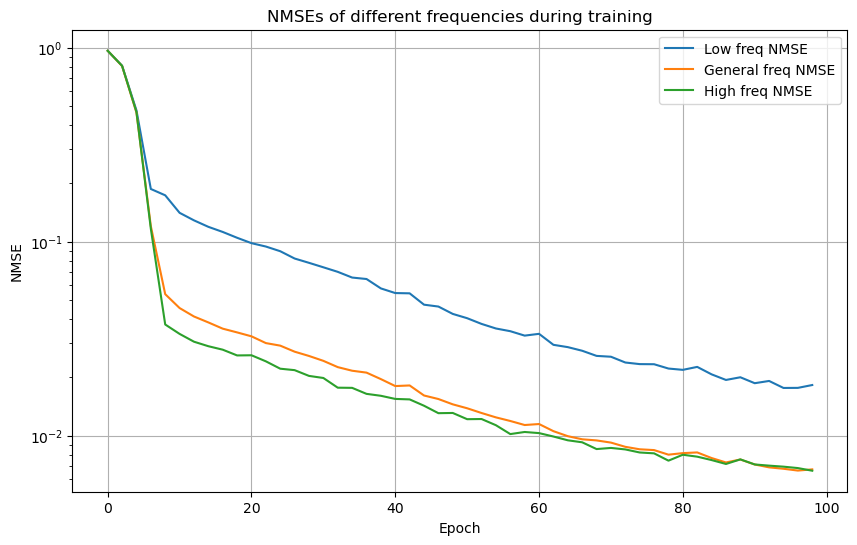

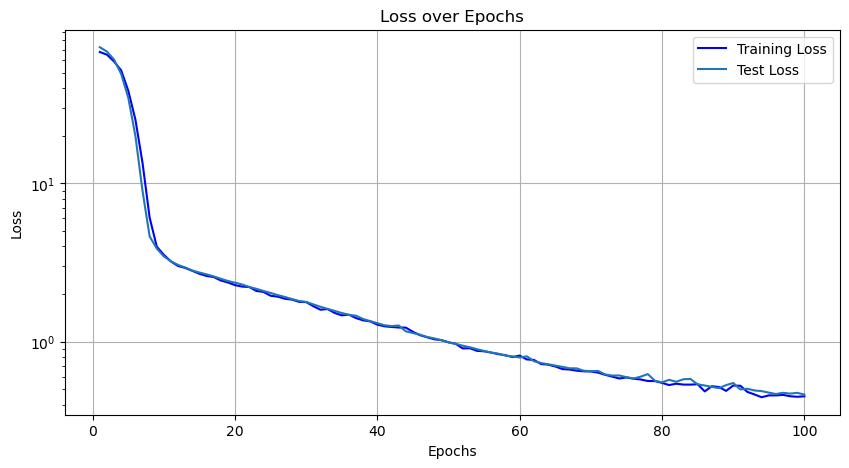

In [227]:
set_seed(101)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training_plots(L3ModelK3_low, train_dataloader_g, test_dataloader_g,\
    num_epochs=100, split_freq=50, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', residue=True, lr=1e-3, nmse=False)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Experiments with training on different datasets

3 layers, kernel size 3

### Training on low frequency dataset only

In [ ]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

# train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
#     num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first', nmse=True)
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [ ]:
print_metrics(L3ModelK3_low)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9992063641548157
NMSE over high freq test functions: 0.9992488622665405


In [ ]:
(0.08218340575695038 - 0.001168005052022636) / 0.001168005052022636

69.36220058691806